<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Векторизация-текста" data-toc-modified-id="Векторизация-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Векторизация текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#KNeighborsClassifier" data-toc-modified-id="KNeighborsClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>KNeighborsClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Описание целей и задачи проекта**

Заказчик, интернет-магазин «Викишоп», запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак. Набор данных содержит разметку о токсичности правок.


**План работы**

1. Загрузить и подготовьте данные.
2. Обучить разные модели. 
 - Метрика качества *F1* должна быть не меньше 0.75. 
3. Сделайть выводы.

## Подготовка

In [1]:
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en

In [24]:
# импорт библиотек
import os
import time
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt


# для моделей
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer



# для работы с текстом
import sys
import spacy
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 

In [3]:
# пути к файлам
pth1 = '/datasets/toxic_comments.csv'
pth2 = '/Users/refresh/Downloads/toxic_comments.csv'

# открытие файлов
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something wrong!')

In [4]:
# знакомимся с информацией
display(data.head(5))
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Посмотрим столбец 'Unnamed: 0':

count    159292.000000
mean      79725.697242
std       46028.837471
min           0.000000
25%       39872.750000
50%       79721.500000
75%      119573.250000
max      159450.000000
Name: Unnamed: 0, dtype: float64

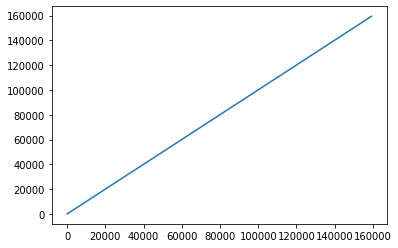

In [5]:
# знакомимся с данными
display(data['Unnamed: 0'].describe())
data['Unnamed: 0'].plot();

Видно, что 'Unnamed: 0' это индекс, удалим этот столбец.

In [6]:
# удаляем столбец
data.drop('Unnamed: 0', axis=1, inplace=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

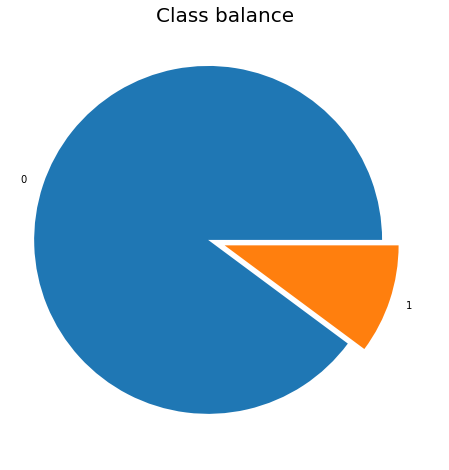

In [7]:
# смотрим баланс классов
display(data['toxic'].value_counts(normalize=True))
# строим пирог
plt.figure(figsize=(8, 8))
plt.title('Сlass balance',fontsize=20)
plt.pie(data['toxic'].value_counts(normalize=True), labels=['0', '1'], explode=(0.1, 0))
plt.show();

В данных нет пропусков.

Удалили лишнее. Язык комментариев - Английский.

В данных всего 10% положительных комментариев.

### Подготовка признаков

Лемматизируем текст

In [8]:
# понижаем регистр
data['text'] = data['text'].str.lower()

In [9]:
# убираем не нужные символы
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ',  x))
data['text'][0]

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0


In [10]:
# отключаем предепреждения
warnings.filterwarnings('ignore')

display(data['text'][0])
nlp = spacy.load("en_core_web_sm")

def gg2(text):
    for i in range(len(text)):
        text[i] = nlp(text[i])
        text[i] = " ".join([token.lemma_ for token in text[i]])
gg2(data['text'])

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now             '

In [11]:
data['text'][0]

'explanation why the edit make under my username hardcore metallica fan be revert   they weren t vandalisms   just closure on some gas after I vote at new york doll fac   and please don t remove the template from the talk page since I m retire now             '

In [12]:
data['text'] = data['text'].apply(lambda x: " ".join(x.split()))
data['text'][0]

'explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalisms just closure on some gas after I vote at new york doll fac and please don t remove the template from the talk page since I m retire now'

In [13]:
X = data['text']
y = data['toxic']
print('начальный размер', X.shape, y.shape)

начальный размер (159292,) (159292,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)
print('валидационная выборка', X_train.shape, y_train.shape)
print('тестовая выборка', X_test.shape, y_test.shape)

валидационная выборка (119469,) (119469,)
тестовая выборка (39823,) (39823,)


### Векторизация текста

In [15]:
# скачиваем стоп-словав
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
# создаём счётчик величин TF-IDF
tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# преобразовываем признаки
tf_idf_train = tf_idf.fit_transform(X_train)
print(tf_idf_train.shape, y_train.shape)
tf_idf_test = tf_idf.transform(X_test)
print(tf_idf_test.shape)

(119469, 127897) (119469,)
(39823, 127897)


## Обучение

### LogisticRegression

<div class="alert alert-block alert-info">
<b>LogisticRegression</b> Считает 9 мин. Запускал код ниже. Оставил лучшие параметры.
    

    model_lr = LogisticRegression()
    grid = {'penalty': ['l1','l2'],
            'C': [0.001,0.01,0.1,1,10,100,1000]}

    grid_lr = GridSearchCV(model_lr, grid, cv=3, n_jobs=-1, scoring='f1')
    grid_lr.fit(tf_idf_train, y_train)


   
    Лучшие параметры модели {'C': 10, 'penalty': 'l2'}
    F1 0.7616593544940224
</div>

In [26]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search
model_lr = LogisticRegression()
grid = {'penalty': ['l1','l2'],
        'C': [0.001,0.01,0.1,1,10,100,1000]}

grid_lr = GridSearchCV(model_lr, grid, cv=3, n_jobs=-1, scoring='f1')
grid_lr.fit(tf_idf_train, y_train)
# фиксируем время
stop = time.time()

In [27]:
print('LogisticRegression для подбора параметров требует', round((stop - start)/60, 2), 'минут')
print(f'Лучшие параметры модели {grid_lr.best_params_}')
print('F1', abs(grid_lr.best_score_))

LogisticRegression для подбора параметров требует 8.72 минут
Лучшие параметры модели {'C': 10, 'penalty': 'l2'}
F1 0.7680179167583226


### LGBMRegressor

<div class="alert alert-block alert-info">
<b>LGBMRegressor</b> Считает догло. Запускал код ниже. Оставил лучшие параметры.
    

    model_LGBM = LGBMClassifier()
    grid = {'num_leaves': [3, 7, 10],
            'learning_rate': [0.1, 0.03],
            'max_depth': [4, 6, 10]
    }

    grid_LGBM = GridSearchCV(model_LGBM, grid, cv=3, n_jobs=-1, scoring='f1')
    grid_LGBM.fit(tf_idf_train, y_train)


   
    Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
    F1 0.6644001463587362
</div>

In [28]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search

model_LGBM = LGBMClassifier()
grid = {'num_leaves': [10],
        'learning_rate': [0.1],
        'max_depth': [10]
}

grid_LGBM = GridSearchCV(model_LGBM, grid, cv=3, n_jobs=-1, scoring='f1')
grid_LGBM.fit(tf_idf_train, y_train)
# фиксируем время
stop = time.time()

In [29]:
print('LGBMRegressor для подбора параметров требует', round((stop - start)/60, 2), 'минут')
print(f'Лучшие параметры модели {grid_LGBM.best_params_}')
print('F1', abs(grid_LGBM.best_score_))

LGBMRegressor для подбора параметров требует 5.22 минут
Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
F1 0.6830699763449192


### KNeighborsClassifier

<div class="alert alert-block alert-info">
<b>CatBoostClassifier</b> Считает догло. Запускал код ниже, считал 25, результат низкий
    

    model_KNN = KNeighborsClassifier()
    grid = {'n_neighbors': [3],
            'p': [1]
           }

    grid_KNN = GridSearchCV(model_KNN, grid, cv=3, n_jobs=-1, scoring='f1')
    grid_KNN.fit(tf_idf_train, y_train)

    KNeighborsClassifier для подбора параметров требует 25.61 минут
    F1 0.1901840693729362
</div>

### CatBoostClassifier

<div class="alert alert-block alert-info">
<b>CatBoostClassifier</b> Считает очень догло. Запускал код ниже, считал около 7 часов. F1 = 0.74
    
    model_cat = CatBoostClassifier(verbose=100)
    grid = {'learning_rate': [0.03, 0.1],
            'max_depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7]}

    grid_cat = GridSearchCV(model_cat, grid, cv=3, n_jobs=-1, scoring='f1')
    grid_cat.fit(tf_idf_train, y_train)
    
    
    CatBoostClassifier для подбора параметров требует 429.25 минут
    Лучшие параметры модели {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 6}
    F1 0.748983782032207
</div>

## Тестирование

In [30]:
mod = LogisticRegression(C=10, penalty='l2')
start = time.time()
mod.fit(tf_idf_train, y_train)
stop = time.time()
print('для обучения требуется', round((stop - start)/60, 2), 'минут')

f1_test = f1_score(y_test, mod.predict(tf_idf_test))
print('F1 на тестовой выборке =', f1_test)

для обучения требуется 0.6 минут
F1 на тестовой выборке = 0.7814004677397166


Проверим модель на адекватность.

In [31]:
const = pd.Series(data=1, index=y_test.index)
f1_const = f1_score(y_test, const)
print('F1 на константных пердсказаниях =', f1_const)

F1 на константных пердсказаниях = 0.18445827349609065


## Выводы

Было произведено ознакомление и предобработка данных. Баланс классов 90% - "0", 10% - "1".

Текст был лемматизирован и векторизирован при помощи TF-IDF.

Обучены следующие модели

**LogisticRegression**

    Лучшие параметры модели {'C': 10, 'penalty': 'l2'}
    F1 = 0.76

**LGBMRegressor**

    Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
    F1 = 0.68

**KNeighborsClassifier**

    Для подбора параметров требует 25.61 минут
    Лучшие параметры модели {'n_neighbors': 3, 'p': 1}
    F1 = 0.19

    
**CatBoostClassifier**

    Для подбора параметров требует более 5 часов
    F1 = 0.75


Лучше всех показала себя модель **LogisticRegression**

    для обучения требуется 0.6 минут
    F1 на тестовой выборке = 0.78

Модель прошла проверку на адекватность.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны